In [68]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from model import BulkComposition
from model.density import OneDDensityModel, planet_core_pressure, SimpleDensityModel
from model.sphere import Layer, Planet, plot_layers, plot_density_function, Sphere

matplotlib.rcParams["font.sans-serif"] = "Comic Code Ligatures"
matplotlib.rcParams["font.family"] = "sans-serif"

# Parameters

In [69]:
bsm_model = "../model/data/bsm_yoshizaki_2020.csv"
density_model_file = "../model/data/density_brennan_2020.csv"

# Load BSM Model from Yoshizaki, 2020

In [70]:
bsm = BulkComposition.from_csv_model(bsm_model)
pd.DataFrame(
    [{"Oxide": k, "Weight (pct)": v} for k, v in bsm.oxides_wt_pct.items()]
).set_index("Oxide").sort_values(by="Weight (pct)", ascending=False)

,Weight (pct)
Oxide,
SiO2,45.500
MgO,31.000
FeO,14.700
Al2O3,3.590
CaO,2.880
Cr2O3,0.880
Na2O,0.590
MnO,0.370
TiO2,0.170


## Calculate molar mass ratio per element

In [71]:
pd.DataFrame(
    [{"Element": k, "Weight (pct)": v} for k, v in bsm.molar_masses().items()]
).set_index("Element").sort_values(by="Weight (pct)", ascending=False)

,Weight (pct)
Element,
O,0.430437
Si,0.212814
Mg,0.187057
Fe,0.114332
Ca,0.020596
Al,0.019012
Cr,0.006025
Na,0.004380
Mn,0.002867


In [72]:
total_r = 3390
# total_mass = np.float64(6.39e23)
total_mass = np.float64(6.417e23)
depths = np.array([0, 55, 1790, 3390])
boundaries = total_r - depths

# crust_dm = SimpleDensityModel(density=3010)
crust_dm = SimpleDensityModel(density=2582)
mantle_dm = OneDDensityModel.from_csv(
    path=density_model_file,
    upper_depth=depths[1] * 1000,
    lower_depth=depths[2] * 1000,
    total_radius=total_r * 1000,
)

crust = Layer.of_km(
    name="crust", outer_r=boundaries[0], inner_r=boundaries[1], color="brown"
).set_density_model(crust_dm)

mantle = Layer.of_km(
    name="mantle", outer_r=boundaries[1], inner_r=boundaries[2], color="gold"
).set_density_model(mantle_dm)

core = Layer.of_km(
    name="core", outer_r=boundaries[2], inner_r=boundaries[3], color="red"
).set_mass(total_mass - crust.mass - mantle.mass)

mars = Planet(total_mass=total_mass, layers=[crust, mantle, core])
mantle.density

3652.8322752687386

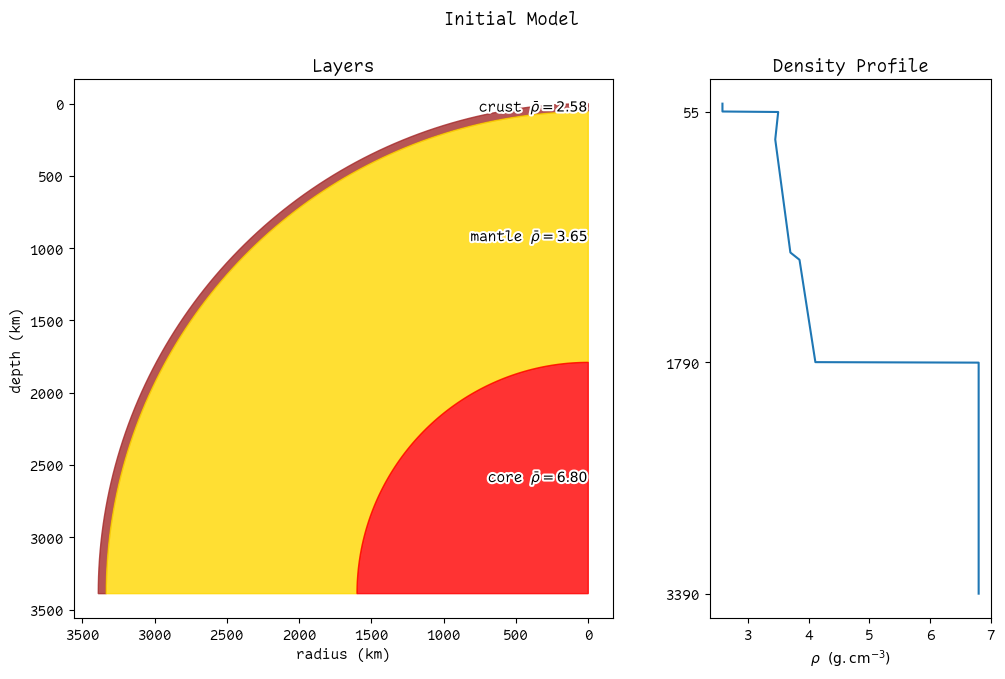

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(12, 7), width_ratios=[2, 1])
plot_layers(mars, axs[0])
plot_density_function(mars, axs[1])
fig.align_ylabels(axs[1])
fig.suptitle(
    "Initial Model",
    horizontalalignment="center",
    verticalalignment="top",
    x=0.5,
)
fig.savefig("../figures/stepwise1.png")

Based on above model, mass of core is ...

First order pressure of core centre is ...

$ P_c = \frac{3Gm2}{8\pi{}R^4}$

In [74]:
planet_core_pressure(total_mass, total_r * 1000)

49680092996.195015

In [75]:
vol = 2.56e22 / 3010
vol

8.504983388704318e+18

In [76]:
crust.volume

7.814601246462935e+18

In [77]:
core_d = 6910
core_m = 1.17e23
core_v = core_m / core_d
core_r = np.cbrt(core_v / ( 4/3 * np.pi))
total_r*1000 - core_r

1797034.384038352

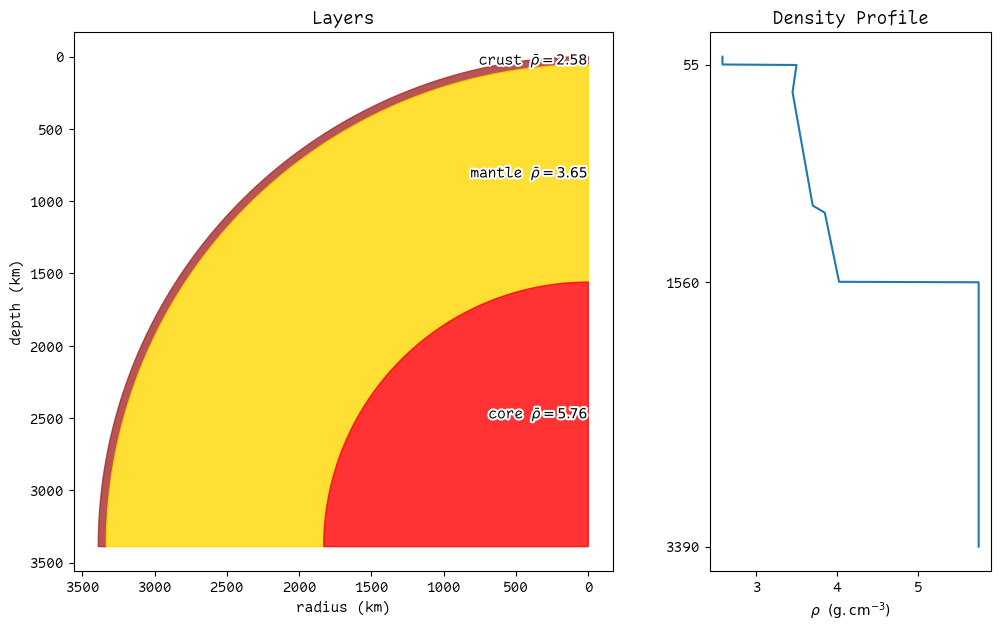

In [81]:
import copy
mars2 = copy.deepcopy(mars)
# new core r = 1830km
mars2.layers[1].inner = Sphere.of_km(1830)
mars2.layers[2] = Layer.of_km(
    name="core", outer_r=1830, inner_r=0, color="red"
).set_mass(total_mass - mars2.layers[0].mass - mars2.layers[1].mass)

fig2, axs2 = plt.subplots(1, 2, figsize=(12, 7), width_ratios=[2, 1])
plot_layers(mars2, axs2[0])
plot_density_function(mars2, axs2[1])
fig.align_ylabels(axs2[1])